In [1]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
BASE = "/media/dtsarev/SatSSD/data"
AUDIO_DIR = f"{BASE}/audio"
TRAIN_CSV = f"{BASE}/train_split.csv"
VAL_CSV   = f"{BASE}/valid_split.csv"
EMB_DIR = "./embeddings_wav2vec"
MODEL_NAME = "facebook/wav2vec2-base"

SR           = 16_000   # target sample‑rate
MAX_SEC      = 12       # max audio length (sec)
BATCH_SIZE   = 32
LR           = 1e-4
EPOCHS       = 30
CLIP_NORM    = 1.0
PATIENCE     = 5
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
os.makedirs(EMB_DIR, exist_ok=True)

In [5]:
proc = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
w2v  = Wav2Vec2Model.from_pretrained(MODEL_NAME).to(DEVICE).eval()

@torch.no_grad()
def extract_w2v(path):
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav[:, :SR * MAX_SEC]
    wav = (wav - wav.mean()) / (wav.std() + 1e-6)
    inp = proc(wav.squeeze().numpy(), sampling_rate=SR, return_tensors="pt", padding=True)
    hidden = w2v(inp.input_values.to(DEVICE)).last_hidden_state.squeeze(0).cpu()
    # Debug: check for NaNs
    if torch.isnan(hidden).any():
        print(f"NaNs detected in wav2vec embeddings for {path}")
    return hidden

for split, csv in [("train", TRAIN_CSV), ("val", VAL_CSV)]:
    df = pd.read_csv(csv, dtype={"Filename":str})
    df["Filename"] = df["Filename"].str.zfill(5)
    for fn in tqdm(df["Filename"], desc=f"{split} feats"):
        save_p = f"{EMB_DIR}/{split}_{fn}.pt"
        if os.path.exists(save_p):
            continue
        try:
            feat = extract_w2v(f"{AUDIO_DIR}/{fn}.mp3")
            torch.save(feat, save_p)
        except Exception as e:
            print("skip", fn, e)

/home/dtsarev/master_of_cv/DIPLOM/repos/venv/lib/python3.11/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


train feats:   0%|          | 0/8072 [00:00<?, ?it/s]

val feats:   0%|          | 0/4588 [00:00<?, ?it/s]

In [6]:
EMOS = ['Admiration','Amusement','Determination','Empathic Pain','Excitement','Joy']

class W2VDataset(Dataset):
    def __init__(self, csv, split):
        df = pd.read_csv(csv, dtype={"Filename":str})
        df["Filename"] = df["Filename"].str.zfill(5)
        self.paths = [f"{EMB_DIR}/{split}_{fn}.pt" for fn in df["Filename"]]
        self.labels = df[EMOS].values.astype(np.float32)
        # Check first vector dim to set globally
        sample_emb = torch.load(self.paths[0])
        self.emb_dim = sample_emb.size(1) * 2  # mean+std concat
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, i):
        emb = torch.load(self.paths[i])            # (T,H)
        mu  = emb.mean(0)
        sig = emb.std(0)
        vec = torch.cat([mu, sig])                 # (2H,)
        return vec, torch.tensor(self.labels[i])


def collate(batch):
    x, y = zip(*batch)
    return torch.stack(x), torch.stack(y)

tr_ds = W2VDataset(TRAIN_CSV, "train")
vl_ds = W2VDataset(VAL_CSV,   "val")
IN_DIM = tr_ds.emb_dim  # dynamic input size

tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
vl_dl = DataLoader(vl_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

In [7]:
class MLP(nn.Module):
    def __init__(self, in_dim, hid=512, out_dim=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, hid),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hid, hid//2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hid//2, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(IN_DIM).to(DEVICE).to(DEVICE)

In [8]:
criterion = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.5, patience=2)
scaler = GradScaler()

tr_losses, val_losses = [], []
best = float('inf'); wait = 0
for epoch in range(1, EPOCHS + 1):
    # --- train
    model.train(); tl = 0
    for xb, yb in tqdm(tr_dl, desc=f"Train {epoch}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimiser.zero_grad()
        with autocast():
            preds = model(xb)
            loss = criterion(preds, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimiser)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimiser); scaler.update()
        tl += loss.item()
    tl /= len(tr_dl)

    # --- val
    model.eval(); vl = 0
    with torch.no_grad():
        for xb, yb in vl_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            vl += criterion(preds, yb).item()
    vl /= len(vl_dl)

    tr_losses.append(tl); val_losses.append(vl)
    scheduler.step(vl)
    print(f"Epoch {epoch}: train {tl:.4f}, val {vl:.4f}")
    if vl < best:
        best = vl; wait = 0; torch.save(model.state_dict(), 'best_audio_mlp.pth'); print('saved')
    else:
        wait += 1
        if wait >= PATIENCE:
            print('early stop'); break

/tmp/ipykernel_196045/1814323951.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train 1:   0%|          | 0/253 [00:00<?, ?it/s]

/tmp/ipykernel_196045/1814323951.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: train 0.0439, val 0.0384
saved


Train 2:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 2: train 0.0424, val 0.0382
saved


Train 3:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 3: train 0.0420, val 0.0385


Train 4:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 4: train 0.0418, val 0.0380
saved


Train 5:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 5: train 0.0415, val 0.0383


Train 6:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 6: train 0.0414, val 0.0379
saved


Train 7:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 7: train 0.0412, val 0.0386


Train 8:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 8: train 0.0413, val 0.0380


Train 9:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 9: train 0.0409, val 0.0379
saved


Train 10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 10: train 0.0408, val 0.0380


Train 11:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 11: train 0.0406, val 0.0379


Train 12:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 12: train 0.0405, val 0.0393


Train 13:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 13: train 0.0401, val 0.0379


Train 14:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 14: train 0.0399, val 0.0379
saved


Train 15:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 15: train 0.0397, val 0.0381


Train 16:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 16: train 0.0397, val 0.0379


Train 17:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 17: train 0.0396, val 0.0378
saved


Train 18:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 18: train 0.0396, val 0.0384


Train 19:   0%|          | 0/253 [00:00<?, ?it/s]

KeyboardInterrupt: 

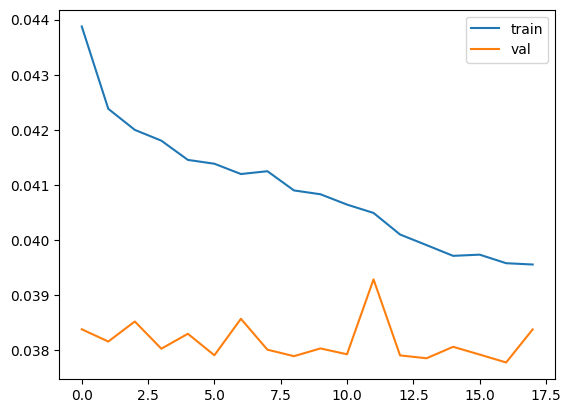

In [9]:
plt.plot(tr_losses, label='train'); plt.plot(val_losses, label='val'); plt.legend(); plt.show()